In [2]:
from tika import parser
import os
from os import listdir
from os.path import isfile, join
import re
from collections import defaultdict
import time
from datetime import date, timedelta
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

In [3]:
# hard-coded values
# path of morningstar recommendations, pdfs
path = "process-pdf/"
# ticker of standard&poor's
SNP = {'^GSPC': 0}

#v alues from user input
# day is input from drop box
day = "2018-02-23"
# traillngTime is input from check box
traillngTime = 180
# trading quantity: threeStarVolume, fourStarVolume, fiveStarVolume
threeStarVolume = 0
fourStarVolume = 0
fiveStarVolume = 900

#processed data
day = ''.join(day.split('-'))
report_date = date(int(day[0:4]),int(day[4:6]),int(day[6:8]))
end_date = report_date+timedelta(days=traillngTime)
shares = {0: 100, 3: threeStarVolume, 4: fourStarVolume, 5: fiveStarVolume}

In [4]:
def retriveFiles(path):
    return [join(path, f) for f in listdir(path) if isfile(join(path, f)) and '.DS' not in f]

In [5]:
files = retriveFiles(path)

In [6]:
# from PyPDF2 import PdfFileReader, PdfFileWriter
 
# def pdf_splitter(path, name):
#     fname = os.path.splitext(os.path.basename(path))[0]
 
#     pdf = PdfFileReader(path)
#     pdf_writer = PdfFileWriter()
#     for page in range(pdf.getNumPages()):
#         if page != 0:
#             if "Best Ideas" in pdf.getPage(page).extractText():
#                 pdf_writer.addPage(pdf.getPage(page))
#     output_filename = '{}.pdf'.format(name)
#     with open(output_filename, 'wb') as out:
#         pdf_writer.write(out)

In [7]:
def generateDates(files):
    root = len(path)
    res = []
    for file in files:    
        dstr = file[root:root+8]
        d = date(int(dstr[0:4]),int(dstr[4:6]),int(dstr[6:8])).strftime("%Y-%m-%d")
        res.append(d)
    #         pdf_splitter(file, dstr)
    res.sort()
    return res

In [8]:
days = generateDates(files)

In [9]:
def retrieveRatings(files, day):
    for file in files:
        if day in file:
            break
    raw = parser.from_file(file)
    pattern = '\(.+\) Q+'
    data_pairs = re.findall(pattern, raw['content'])
    res = defaultdict(int)
    for data in data_pairs:
        pair = data.split(' ');
        res[pair[0][1:-1]] = len(pair[1])
        
    return res

In [10]:
ticker_rating_pair = retrieveRatings(files, day)

In [11]:
# # Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
# tickers = ['0700', 'MSFT', '^GSPC']

# # We would like all available data from 01/01/2000 until 12/31/2016.
# report_date = datetime(2018, 3, 7)
# end_date = datetime(2018, 3, 15)

# # User pandas_reader.data.DataReader to load the desired data. As simple as that.
# panel_data = data.DataReader('MSFT', 'yahoo', report_date, end_date)

# for ticker in tickers:
#     try:    
#         print(ticker, data.DataReader(ticker, 'yahoo', report_date, end_date).iloc[0]['Close'], sep = ": $")
#     except:
#         print(ticker, " is not public traded in North America stock market, ignored...", sep = "")

In [12]:
# [pd.to_datetime(d).strftime("%m/%d/%Y") for d in list(panel_data.index.values)]

In [13]:
#get open and close prices from yahoo api
#return dic {ticker: [rating, [price1, price2, ...]], ...}
def getTickerPrices(report_date, end_date, ticker_rating_pair):
    res = defaultdict(list)
    for ticker, rating in ticker_rating_pair.items():
        try:    
            price_info = data.DataReader(ticker, 'yahoo', report_date, end_date)
            prices = []
            for i in range (price_info.shape[0]):
                prices.append(price_info.iloc[i]['Close'])
            res[ticker] = [rating, prices]
        except:
            print(ticker, " is not public traded in North America stock market, ignored...", sep = "")
    return res

In [14]:
ticker_prices = getTickerPrices(report_date, end_date, ticker_rating_pair)
snp_prices = getTickerPrices(report_date, end_date, SNP)

ESRX is not public traded in North America stock market, ignored...
HSO is not public traded in North America stock market, ignored...
RHC is not public traded in North America stock market, ignored...
SHP is not public traded in North America stock market, ignored...
392 is not public traded in North America stock market, ignored...
BXB is not public traded in North America stock market, ignored...
1 is not public traded in North America stock market, ignored...
GFS is not public traded in North America stock market, ignored...
G1A is not public traded in North America stock market, ignored...
525 is not public traded in North America stock market, ignored...
KGX is not public traded in North America stock market, ignored...
PHIA is not public traded in North America stock market, ignored...
AOG is not public traded in North America stock market, ignored...
6762 is not public traded in North America stock market, ignored...
700 is not public traded in North America stock market, ignor

In [35]:
#calculate daily profits
#return list [profit1, profit2]
#prices: dict {ticker: [rating, [price1, price2, ...]], ...}
#shares: dict {3: quantity, 4: quantity, 5: quantity}

def calculateProfits(ticker_prices, shares):
    balance  = [0] * len(next(iter(ticker_prices.values()))[1])
    
    for ticker, ops in ticker_prices.items():
        rating = ops[0]
        prices = ops[1]
        for i in range(len(balance)):
            balance[i] = balance[i] + prices[i]*shares[rating]
    profits_percentage = [0] * len(balance)
    for i in range(len(balance)):
        profits_percentage[i] = (balance[i]-balance[0])/balance[0]*10
    return profits_percentage

In [36]:
profits = calculateProfits(ticker_prices, shares)

profits_snp = calculateProfits(snp_prices, shares)

In [37]:
def getDealDays(report_date, end_date, ticker):
    panel_data = data.DataReader(ticker, 'yahoo', report_date, end_date)
    return [pd.to_datetime(d).strftime("%y/%m/%d") for d in list(panel_data.index.values)]

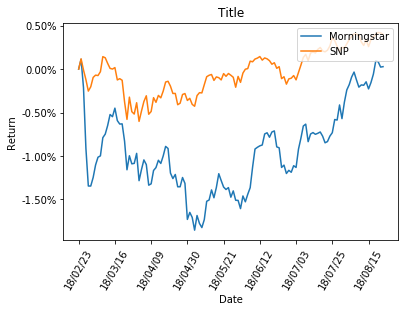

In [38]:
import matplotlib.ticker as mtick
deal_days =  getDealDays(report_date, end_date, '^GSPC')

# plot_data_ms = {'Date': deal_days, 'Return': profits}
# plot_data_snp = {'Date': deal_days, 'Return': profits_snp}

l1, = plt.plot(deal_days,profits, label='Morningstar')
l2, = plt.plot(deal_days,profits_snp, label='SNP')
plt.legend(loc='upper right')
plt.title('Title')
plt.xlabel('Date')
plt.ylabel('Return')
plt.xticks(rotation=60)
plt.gca().axes.get_xaxis().set_major_locator(plt.MaxNLocator(10))
plt.gca().axes.get_yaxis().set_major_formatter(mtick.PercentFormatter())
plt.savefig('myfig.png')

In [18]:
# plot_data_ms = {'Date': [1,2,3], 'Return': [0.1,0.1,0.2]}
# plot_data_snp = {'Date': [1,2,3], 'Return': [0.3,0.2,0.2]}
# deal_days = ['18/02/23', '18/02/26', '18/02/27', '18/02/28', '18/03/01', '18/03/02', '18/03/05', '18/03/06', '18/03/07', '18/03/08', '18/03/09', '18/03/12', '18/03/13', '18/03/14', '18/03/15', '18/03/16', '18/03/19', '18/03/20', '18/03/21', '18/03/22', '18/03/23', '18/03/26']
# profits = [0.0, 0.011250767030616247, -0.02146339311365684, -0.09132479797393143, -0.13458839108681125, -0.13461644316495383, -0.12476853690902681, -0.11034731244769601, -0.10145333203943435, -0.09991022157684723, -0.07895176586975683, -0.07485546677796452, -0.06495144566293734, -0.05229783926326188, -0.05479491303336689, -0.04497501604432241, -0.05928397332760033, -0.06329610548214988, -0.06307166745137922, -0.08299196080526396, -0.1159025818218702, -0.0997699290776893]
# profits_snp = [i+0.1 for i in profits]

In [ ]:
import matplotlib
matplotlib.use("TkAgg")
import tkinter.scrolledtext as tkst
import numpy as np


from tkinter import *
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
from pandas import DataFrame
import tkinter as tk
# purchaseDate = 'YYYY-MM-DD'
# threeStarVolume, fourStarVolume, fiveStarVolume
# trailingTime

root = Tk()
root.geometry('1000x600')
root.title("Morningstar Strategy Simulator")
root.resizable(False, False)

# df1 = DataFrame(plot_data_ms,columns=['Date','Return'])
# df1 = df1[['Date', 'Return']].groupby('Date').sum()

# Data2 = {'Year': [1920,1930,1940,1950,1960,1970,1980,1990,2000,2010],
#         'Unemployment_Rate': [9.8,12,8,7.2,6.9,7,6.5,6.2,5.5,6.3]
#        }
  
# df2 = DataFrame(Data2,columns=['Year','Unemployment_Rate'])
# df2 = df2[['Year', 'Unemployment_Rate']].groupby('Year').sum()

# df2 = DataFrame(plot_data_ms,columns=['Date','Return'])
# df2 = df2[['Date', 'Return']].groupby('Date').sum()


# df3 = DataFrame(plot_data_snp,columns=['Date','Return'])
# df3 = df3[['Date', 'Return']].groupby('Date').sum()

f = Figure(figsize=(5,5), dpi=100)

ax2 = f.add_subplot(111)
ax2.plot(deal_days,profits)
ax3 = f.add_subplot(111)
ax3.plot(deal_days,profits_snp)
ax2.set_title('Title')
f.autofmt_xdate(bottom=0.2, rotation=90, ha='right', which=None)
f.legend((ax2, ax2),
        ('label1', 'label2'),
        loc='upper right')
canvas = FigureCanvasTkAgg(f, root)

# # line = FigureCanvasTkAgg(f, root)
# # line.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH)
# # df2.plot(kind='line', legend=True, ax=ax2, color='r',marker='o', fontsize=10)
# ax2.set_title('Title')

# ax3 = f.add_subplot(111)
# df3.plot(kind='line', legend=True, ax=ax3, color='r',marker='o', fontsize=10)



canvas.draw()
canvas.get_tk_widget().grid(row = 3, rowspan = 6, column = 3, columnspan = 6, sticky = "N" + "S" + "E" + "W")

while True:
    try:
        root.mainloop()
        break
    except UnicodeDecodeError:
        pass

/usr/local/lib/python3.7/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x130326b00> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


In [18]:
def getFormatedTickerPrice(ticker_prices, shares):
    s = "Ticker Quantity Open_Price Close_Price\n"
    for ticker, ops in ticker_prices.items():
        ticker = "{:<6}".format(ticker)
        rating = ops[0]
        rating = "{:<8}".format(str(shares[rating]))
        s = s + ticker + ' ' + rating
        prices = ops[1]
        open_price = "{:<10}".format( str(round(prices[0],2)) )
        close_price = "{:11}".format( str(round(prices[-1],2)) )
        s = s + ' '+  open_price +' '+ close_price
        s = s+'\n'
    return s

In [23]:
print(getFormatedTickerPrice(ticker_prices, shares))

NameError: name 'getFormatedTickerPrice' is not defined

In [3]:
from tkinter import *
from PIL import ImageTk, Image
import os

root = Tk()
img = ImageTk.PhotoImage(Image.open("myfig.png"))
panel = Label(root, image = img)
panel.pack(side = "bottom", fill = "both", expand = "yes")
root.mainloop()

In [ ]:
from tika import parser
import os
from os import listdir
from os.path import isfile, join
import re
from collections import defaultdict
import time
from datetime import date, datetime
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.use("TkAgg")
import tkinter.scrolledtext as tkst
import numpy as np
from datetime import timedelta
from pandas import DataFrame
import tkinter as tk
from tkinter import *
from tkinter import ttk
from PIL import Image, ImageTk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

path = "process-pdf/"
SNP = {'^GSPC': 0}
shares = {0:1200, 3: 200, 4: 400, 5: 800}

def retriveFiles(path):
    return [join(path, f) for f in listdir(path) if isfile(join(path, f)) and '.DS' not in f ]

files = retriveFiles(path)

def generateDates(files):
    root = len(path)
    res = []
    for file in files:    
        dstr = file[root:root+8]
        d = date(int(dstr[0:4]),int(dstr[4:6]),int(dstr[6:8]))
        res.append(d)
    
    res.sort()
    return res

def retrieveRatings(files, day):
    for file in files:
        if day in file:
            break
    raw = parser.from_file(file)
    pattern = '\(.+\) Q+'
    data_pairs = re.findall(pattern, raw['content'])
    res = defaultdict(int)
    for data in data_pairs:
        pair = data.split(' ');
        res[pair[0][1:-1]] = len(pair[1])
        
    return res

#get open and close prices from yahoo api
#return dic {ticker: [rating, [price1, price2, ...]], ...}
def getTickerPrices(report_date, end_date, ticker_rating_pair):
    res = defaultdict(list)
    for ticker, rating in ticker_rating_pair.items():
        try:    
            price_info = data.DataReader(ticker, 'yahoo', report_date, end_date)
            prices = []
            for i in range (price_info.shape[0]):
                prices.append(price_info.iloc[i]['Close'])
            res[ticker] = [rating, prices]
        except:
            print(ticker, " is not public traded in North America stock market, ignored...", sep = "")
    return res

def calculateBalance(ticker_prices, shares):
    balance  = [0] * len(next(iter(ticker_prices.values()))[1])
    
    for ticker, ops in ticker_prices.items():
        rating = ops[0]
        prices = ops[1]
        for i in range(len(balance)):
            balance[i] = balance[i] + prices[i]*shares[rating]
    return balance

def calculateProfits(balance, shares):
    profits_percentage = [0] * len(balance)
    for i in range(len(balance)):
        profits_percentage[i] = (balance[i] - balance[0]) / balance[0]
    return profits_percentage

def getFormatedTickerPrice(ticker_prices, shares):
    s = "Ticker  Quantity   Buy($)  Sell($)\n"
    for ticker, ops in ticker_prices.items():
        ticker = "{:<7}".format(ticker)
        rating = ops[0]
        rating = "{:<10}".format(str(shares[rating]))
        s = s + ticker + ' ' + rating
        prices = ops[1]
        open_price = "{:<8}".format( str(round(prices[0],2)) )
        close_price = "{:<7}".format( str(round(prices[-1],2)) )
        s = s + ' '+  open_price +' '+ close_price
        s = s+'\n'
    return s

# purchaseDate = 'YYYYMMDD'
# threeStarVolume, fourStarVolume, fiveStarVolume
# trailingTime

root = Tk()
root.geometry('1000x610')
root.title("Morningstar Strategy Simulator")
root.resizable(False, False)

lf_dataRange = LabelFrame(root, text = "Data Range")
lf_dataRange.grid(row = 0, column = 0, columnspan = 2, padx = 5, pady = 5)

# awaiting filename data
# generateDates(files)
dataRange = generateDates(files)
dataRangeSelect = ttk.Combobox(lf_dataRange, state="readonly", values = dataRange)
dataRangeSelect.pack()
dataRangeSelect.current(1)

day = ''

def callbackFunc(event):
    print("New Element Selected", dataRangeSelect.get())
    day = ''.join(str(dataRangeSelect.get()).split('-'))
    print(day)
    if (day == ''):
        day = '20180223'
    report_date = date(int(day[0:4]),int(day[4:6]),int(day[6:8]))
    ticker_rating_pair = retrieveRatings(files, day)
    print(day)
    
dataRangeSelect.bind("<<ComboboxSelected>>", callbackFunc)

# lf_purchaseDate = LabelFrame(root, text = "Purchase Date (YYYYMMDD)")
# lf_purchaseDate.grid(row = 1, column = 0, columnspan = 2, padx = 5, pady = 5)
# entry_purchaseDate = Entry(lf_purchaseDate, bd = 2)
# entry_purchaseDate.pack()
# day = str(entry_purchaseDate.get())
# if (day == ''):
#     day = '20180808'
# report_date = date(int(day[0:4]),int(day[4:6]),int(day[6:8]))

lf_threeStarVolume = LabelFrame(root, text = "3-star Quantity")
lf_threeStarVolume.grid(row = 0, column = 2, columnspan = 2, padx = 5, pady = 5)
entry_threeStarVolume = Entry(lf_threeStarVolume, bd = 2)
entry_threeStarVolume.pack()

lf_fourStarVolume = LabelFrame(root, text = "4-star Quantity")
lf_fourStarVolume.grid(row = 1, column = 2, columnspan = 2, padx = 5, pady = 5)
entry_fourStarVolume = Entry(lf_fourStarVolume, bd = 2)
entry_fourStarVolume.pack()
    
lf_fiveStarVolume = LabelFrame(root, text = "5-star Quantity")
lf_fiveStarVolume.grid(row = 2, column = 2, columnspan = 2, padx = 5, pady = 5)
entry_fiveStarVolume = Entry(lf_fiveStarVolume, bd = 2)
entry_fiveStarVolume.pack()

lf_TrailingTime = LabelFrame(root, text = "Trailing Return Days")
lf_TrailingTime.grid(row = 0, rowspan = 2, column = 4, columnspan = 2, padx = 5, pady = 5, sticky = "N" + "S")
MODES = [
    ("5 Days", 5),
    ("30 Days", 30),
    ("91 Days", 91),
    ("180 Days", 180),
]

v = StringVar()
v.set(5)

for text, mode in MODES:
    b = Radiobutton(lf_TrailingTime, text = text, variable = v, value = mode)
    b.pack(anchor = W)

tickerInfo = tkst.ScrolledText(
    master = root,
    wrap   = WORD,
    width  = 20,
    height = 10
)

tickerInfo.grid(row = 3, rowspan = 7, column = 0, columnspan = 3, sticky = "N" + "S" + "E" + "W")

# replace text with a func callback
tickerInfo.insert(INSERT, '')
    
def getDealDays(report_date, end_date, ticker):
    panel_data = data.DataReader(ticker, 'yahoo', report_date, end_date)
    return [pd.to_datetime(d).strftime("%m/%d") for d in list(panel_data.index.values)]

def submitCallback():
    
    day = ''.join(str(dataRangeSelect.get()).split('-'))
    print(day)
    if (day == ''):
        day = '20180223'
    report_date = date(int(day[0:4]),int(day[4:6]),int(day[6:8]))
    print(report_date.strftime("%m/%d"))

    threeStarVolume = int(entry_threeStarVolume.get())
    fourStarVolume = int(entry_fourStarVolume.get())
    fiveStarVolume = int(entry_fiveStarVolume.get())
    shares = {0:1200, 3: threeStarVolume, 4: fourStarVolume, 5: fiveStarVolume}
    trailingTime = int(v.get())
    end_date = report_date + timedelta(days=trailingTime)

    ticker_prices = getTickerPrices(report_date, end_date, retrieveRatings(files, day))
    snp_prices = getTickerPrices(report_date, end_date, SNP)

    balance = calculateBalance(ticker_prices, shares)
    profits = calculateProfits(balance, shares)
    snpBalance = calculateBalance(snp_prices, shares)
    profits_snp = calculateProfits(snpBalance, shares)
    
    balanceLabel = Label(root, text = "Cost: $" + str(round(balance[0], 2)) + "\n EOP Balance: $" + str(round(balance[len(balance) - 1], 2)))
    balanceLabel.grid(row = 2, column = 6, columnspan = 2, padx = 5, pady = 5, sticky = "N" + "S" + "E" + "W")

    deal_days =  getDealDays(report_date, end_date, '^GSPC')
    
    tickerInfo.delete(1.0, END)
    tickerInfo.insert(INSERT, getFormatedTickerPrice(ticker_prices, shares))
    tickerInfo.config(state = DISABLED)
    
#     print(getFormatedTickerPrice(ticker_prices, shares))

    l1, = plt.plot(deal_days,profits, label='Morningstar')
    l2, = plt.plot(deal_days,profits_snp, label='SNP')
    plt.legend(loc='upper right')
    plt.title('Title')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.xticks(rotation=90)
    plt.savefig('myfig.png')

    img = ImageTk.PhotoImage(Image.open("myfig.png"))
    panel = Label(root, image = img)
    panel.grid(row = 3, rowspan = 4, column = 4, columnspan = 4, padx = 5, pady = 5, sticky = "N" + "S" + "E" + "W")
#     img = ImageTk.PhotoImage(Image.open("myfig.png"))
#     panel = Label(root, image = img)
#     panel.grid(row = 3, rowspan = 4, column = 4, columnspan = 4, padx = 5, pady = 5, sticky = "N" + "S" + "E" + "W")

    print("Submitted")
    
    
btn_Submit = Button(root, text = "Submit", command = submitCallback)
btn_Submit.grid(row = 1, column = 6, columnspan = 2, padx = 5, pady = 5, sticky = "N" + "S" + "E" + "W")

for col in range(10):
    root.grid_columnconfigure(col, minsize = 100, pad = 2)

for row in range(10):
    root.grid_rowconfigure(row, minsize = 60, pad = 2)


while True:
    try:
        root.mainloop()
        break
    except UnicodeDecodeError:
        pass

20180302
03/02
BT.A is not public traded in North America stock market, ignored...
941 is not public traded in North America stock market, ignored...
TLS is not public traded in North America stock market, ignored...
BMW is not public traded in North America stock market, ignored...
DMP is not public traded in North America stock market, ignored...
2333 is not public traded in North America stock market, ignored...
IMB is not public traded in North America stock market, ignored...
4452 is not public traded in North America stock market, ignored...
RB. is not public traded in North America stock market, ignored...
RDS.B is not public traded in North America stock market, ignored...
RSPP is not public traded in North America stock market, ignored...
8306 is not public traded in North America stock market, ignored...
QBE is not public traded in North America stock market, ignored...
ESRX is not public traded in North America stock market, ignored...
HSO is not public traded in North Ameri